In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

sys.path.append("../")
from functions import utils, generate_labeled_data

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
project_id = params['project_id']

In [4]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [5]:
# Read data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

template_data.head()

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR493937,3.800154,0.018190,9.128459,1.585803,0.713952,84.990542,19.943002,12.065586,2.498822,7.713002,...,0.00000,0.769525,0.0,0.0,0.000000,0.000000,0.623852,0.588513,0.0,0.000000
SRR493938,3.798473,0.000000,9.157669,1.456017,0.738967,85.788323,19.621252,11.738855,2.435308,7.125808,...,0.00000,0.568761,0.0,0.0,0.000000,0.000000,0.859512,0.452511,0.0,0.000000
SRR493939,20.222134,0.000000,15.522072,3.944919,2.512265,8.072948,47.246078,18.866957,2.443230,12.143670,...,0.00000,0.483164,0.0,0.0,0.000000,0.432895,0.497708,0.446833,0.0,0.000000
SRR493940,19.988329,0.000000,17.140304,3.977217,2.378849,7.599225,46.594458,18.921190,2.448276,12.048960,...,0.07756,0.632984,0.0,0.0,0.000000,0.229307,0.431705,0.462295,0.0,0.168159
SRR493941,3.239231,0.019398,9.069316,2.181582,1.008155,17.675885,19.371137,11.759756,1.970725,6.740705,...,0.00000,0.381622,0.0,0.0,0.070955,0.000000,0.600384,0.739403,0.0,0.000000


In [6]:
# Try different partitions of the data
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]
#template_data = template_data.loc[smRNA_samples]
template_data = template_data.drop(smRNA_samples)
print(template_data.shape)
template_data.head()

(24, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR493937,3.800154,0.018190,9.128459,1.585803,0.713952,84.990542,19.943002,12.065586,2.498822,7.713002,...,0.00000,0.769525,0.0,0.0,0.000000,0.000000,0.623852,0.588513,0.0,0.000000
SRR493938,3.798473,0.000000,9.157669,1.456017,0.738967,85.788323,19.621252,11.738855,2.435308,7.125808,...,0.00000,0.568761,0.0,0.0,0.000000,0.000000,0.859512,0.452511,0.0,0.000000
SRR493939,20.222134,0.000000,15.522072,3.944919,2.512265,8.072948,47.246078,18.866957,2.443230,12.143670,...,0.00000,0.483164,0.0,0.0,0.000000,0.432895,0.497708,0.446833,0.0,0.000000
SRR493940,19.988329,0.000000,17.140304,3.977217,2.378849,7.599225,46.594458,18.921190,2.448276,12.048960,...,0.07756,0.632984,0.0,0.0,0.000000,0.229307,0.431705,0.462295,0.0,0.168159
SRR493941,3.239231,0.019398,9.069316,2.181582,1.008155,17.675885,19.371137,11.759756,1.970725,6.740705,...,0.00000,0.381622,0.0,0.0,0.070955,0.000000,0.600384,0.739403,0.0,0.000000


In [7]:
# Read metadata
metadata = pd.read_csv(
    metadata_file,
    header=0,
    sep='\t',
    index_col=0)

metadata.head()

,source
Sample,
SRR493937,Normal
SRR493938,Normal
SRR493939,Tumor
SRR493940,Tumor
SRR493941,Normal


In [8]:
# PCA encode
pca = PCA(n_components=2)

model = pca.fit(template_data)
template_PCAencoded = model.transform(template_data)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded ,
                                         index=template_data.index,
                                         columns=['1','2'])

In [9]:
# Add tumor/normal labels
template_data_labeled = pd.merge(template_PCAencoded_df, metadata, left_index=True, right_index=True)
template_data_labeled

,1,2,source
SRR493937,-2463.232568,-1750.980134,Normal
SRR493938,-2481.090484,-1748.462727,Normal
SRR493939,263.364323,-1148.304498,Tumor
SRR493940,256.795105,-1122.935584,Tumor
SRR493941,-12934.027566,-3541.517260,Normal
SRR493942,-12931.955577,-3598.031886,Normal
SRR493943,14365.128342,6597.548892,Tumor
SRR493944,14533.977626,6488.885896,Tumor
SRR493945,-11867.494988,-4422.368420,Normal
SRR493946,-11862.428024,-4461.200556,Normal


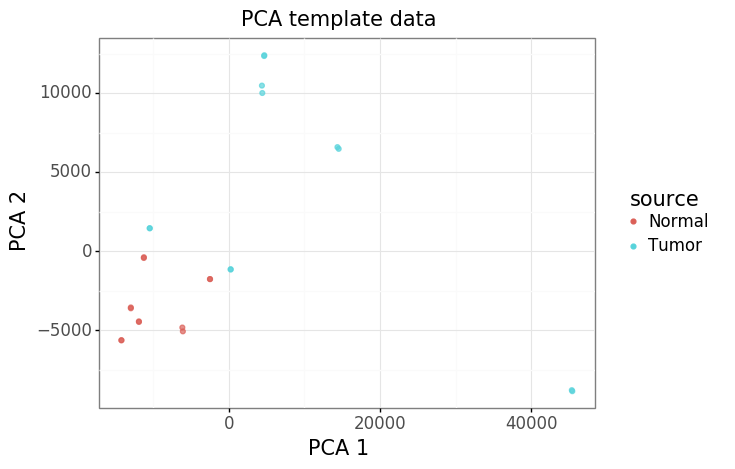

<ggplot: (8755849325693)>


In [10]:
# Plot
fig = ggplot(template_data_labeled, aes(x='1', y='2'))
#fig += ggplot(template_data_labeled[template_data_labeled['source']=='Normal'], aes(x='1', y='2'))
fig += geom_point(aes(color='source'), alpha=0.7)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA template data')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
#fig += ylim(-750000,10)
#fig += xlim(-1000000,-750000)

print(fig)